<a href="https://colab.research.google.com/github/Hotckiss/DUL/blob/hw3_2/hw3p2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
from google.colab import drive

In [0]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
path_ = 'drive/My Drive/hw3-q2.pkl'

In [0]:
def read_data():
    with open(path_, 'rb') as in_file:
        data = pickle.load(in_file)
    X_train_ = dataset['train']
    X_val_ = dataset['valid']

    X_train = []
    X_val = []

    for item in X_train_:
        x = torch.tensor(item, dtype=torch.float32)
        x = x * 2 / 255 - 1
        x = x.permute(2, 0, 1)
        X_train.append(x)

    for item in X_val_:
        x = torch.tensor(item, dtype=torch.float32)
        x = x * 2 / 255 - 1
        x = x.permute(2, 0, 1)
        X_val.append(x)

    return X_train, X_val

In [0]:
def MLLLoss(mu, var, x):
    return (0.5 * (torch.log(np.pi * 2 * var) + (x - mu) ** 2 / var)).mean()

In [0]:
def KLDiv(mu, var):
    return (-0.5 * (1.0 + torch.log(var) - mu ** 2 - var)).mean()

In [0]:
def prob_(mu, var, x):
    return -0.5 * (torch.log(np.pi * 2 * var) + (x - mu) ** 2 / var)

In [0]:
def KLL(mu_z1, var_z1, mu_z2, var_z2, z):
    return (prob_(mu_z1, var_z1, z) - prob_(mu_z2, var_z2, z)).mean()

In [0]:
def plot_(train, val, title_):
    plt.plot(range(epochs), train, label="train")
    plt.plot(range(epochs), val, label="val")
    plt.xlabel('N')
    plt.ylabel(title_)
    plt.legend()
    plt.show()

In [0]:
def plot_interpolation(n, m, images):
    f, axarr = plt.subplots(n, m)
    f.set_figheight(15)
    f.set_figwidth(8)
    for i, img in enumerate(images):
        axarr[n - 1 - i // m, i % m].imshow(img)
        axarr[n - 1 - i // m, i % m].axis('off')
    plt.show()

In [0]:
def plot_samples(images):
    f, axarr = plt.subplots(3, 3)
    f.set_figheight(4)
    f.set_figwidth(4)
    for i, img in enumerate(images):
        axarr[i // 3, i % 3].imshow(img)
        axarr[i // 3, i % 3].axis('off')
    plt.show()

In [0]:
def extract_samples(n, src):
    l = list(range(n))
    return transform(src[l]).to(device), transform(src[l[-1:] + l[:-1]]).to(device)

In [0]:
def transform(x):
    return (torch.tensor(x, dtype=torch.float32) * 2 / 255 - 1).permute(0, 3, 1, 2)

In [0]:
class GatedShortcutConnection(nn.Module):
    def __init__(self, channels=128):
        super(GatedShortcutConnection, self).__init__()
                 
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
                 
    def forward(self, x):
        return self.conv1(x) * self.sigmoid(self.conv2(x))

In [0]:
class ResidualStack(nn.Module):
    def __init__(self, channels=64):
        super(ResidualStack, self).__init__()      
        self.net = nn.Sequential(
            nn.Conv2d(4 * channels, channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channels, channels * 2, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            GatedShortcutConnection(channels=channels * 2),
            nn.ReLU(),
            nn.Conv2d(2 * channels, channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channels, channels * 2, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            GatedShortcutConnection(channels=channels * 2),
            nn.ReLU(),
            nn.Conv2d(2 * channels, channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channels, channels * 2, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            GatedShortcutConnection(channels=channels * 2),
            nn.ReLU(),
            nn.Conv2d(2 * channels, channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channels, channels * 2, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            GatedShortcutConnection(channels=channels * 2),
            nn.ReLU(),
            nn.Conv2d(2 * channels, channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channels, channels * 2, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            GatedShortcutConnection(channels=channels * 2),
            nn.ReLU()
        )
                 
    def forward(self, x):
        return self.net(x)

In [0]:
class VAE(nn.Module):
    def __init__(self, channels=64):
        super(VAE, self).__init__()
        self.channels = channels
        self.encoder = nn.Sequential(
            nn.Conv2d(3, self.channels * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(self.channels * 2, self.channels * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(self.channels * 4, self.channels * 4, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            ResidualStack(self.channels),
            nn.Conv2d(self.channels * 2, self.channels * 4, kernel_size=1)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(self.channels * 2, self.channels * 4, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            ResidualStack(self.channels),
            nn.ConvTranspose2d(self.channels * 2, self.channels * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(),
            nn.ConvTranspose2d(self.channels * 2, 3 * 2, kernel_size=4, stride=2, padding=1, bias=False)
        )
            
    def encode(self, x, training=True):
        x = self.encoder(x).reshape(-1, 2, 2 * self.channels, 8, 8)
        mu, var = x[:, 0], torch.exp(x[:, 1])
        z = mu + torch.sqrt(var) * torch.randn_like(mu, device=device)

        return (mu, var, z) if training else mu
    
    def decode(self, z):
        z = self.decoder(z).reshape(-1, 2, 3, 32, 32)

        return z[:, 0], torch.exp(z[:, 1])
            
    def forward(self, x):
        mu_z, var_z, z = self.encode(x)
        mu_x, var_x = self.decode(z)

        return mu_z, var_z, mu_x, var_x

In [0]:
X_train, X_val = read_data()

In [0]:
epochs = 200
batch_size = 1024

In [0]:
train_loader = data.DataLoader(dataset=X_train, batch_size=batch_size, shuffle=True)
val_loader = data.DataLoader(dataset=X_val, batch_size=batch_size, shuffle=False)

In [0]:
model = VAE(channels=32)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=2e-4)

In [0]:
def train():
    KLD_t, losses_t, var_t, KLD_v, losses_v, var_v = [], [], [], [], [], []

    for i in trange(epochs):
        it_var, it_KLD, it_loss = [], [], []
        model.train()
        for x in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            mu_z, var_z, mu_x, var_x = model(x)
            mll, KL = MLLLoss(mu_x, var_x, x), KLDiv(mu_z, var_z)
            total_loss = mll + KL

            it_var.append(mll.item())
            it_KLD.append(KL.item())
            it_loss.append(total_loss.item())

            total_loss.backward()
            optimizer.step()

        var_t.append(np.array(it_var).mean())
        KLD_t.append(np.array(it_KLD).mean())
        losses_t.append(np.array(it_loss).mean())
        it_var, it_KLD, it_loss = [], [], []

        model.eval()
        with torch.no_grad():
            for x in val_loader:
                x = x.to(device)
                mu_z, var_z, mu_x, var_x = model(x)
                mll, KL = MLLLoss(mu_x, var_x, x), KLDiv(mu_z, var_z)
                total_loss = mll + KL

                it_var.append(mll.item())
                it_KLD.append(KL.item())
                it_loss.append(total_loss.item())

        var_v.append(np.array(it_var).mean())
        KLD_v.append(np.array(it_KLD).mean())
        losses_v.append(np.array(it_loss).mean())

    return var_t, var_v, KLD_t, KLD_v, losses_t, losses_v

In [0]:
var_t, var_v, KLD_t, KLD_v, losses_t, losses_v = train()

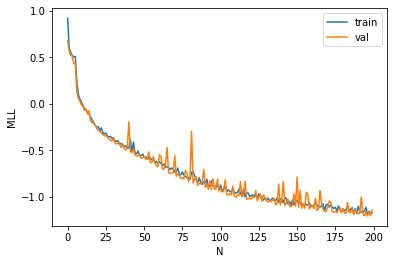

In [0]:
plot_(var_t, var_v, "MLL")

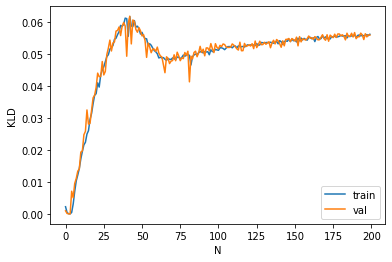

In [0]:
plot_(KLD_t, KLD_v, "KLD")

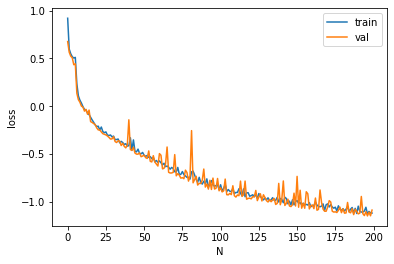

In [0]:
plot_(losses_t, losses_v, "loss")

In [0]:
torch.save(model.state_dict(), "./tmp.pt")

In [0]:
def draw_interpolation(model, n, m):
    idxs = list(range(n))
    sa = torch.stack([X_train[i] for i in idxs]).to(device)
    sb = torch.stack([X_train[i] for i in idxs[-1:] + idxs[:-1]]).to(device)
    images = []

    with torch.no_grad():
        for i in range(n):
            a, b = sa[i], sb[i]
            za, zb = model.encode(a[None, :], training=False), model.encode(b[None, :], training=False)
            for j in range(m):
                x, _ = model.decode(za + (zb - za) * j / (m - 1))
                x = x.permute(0, 2, 3, 1).cpu().numpy()[0]
                images.append(x)
            
    return np.clip((np.array(images) + 1) / 2, 0, 1)

In [0]:
model.eval()
images = draw_interpolation(model, 10, 5)

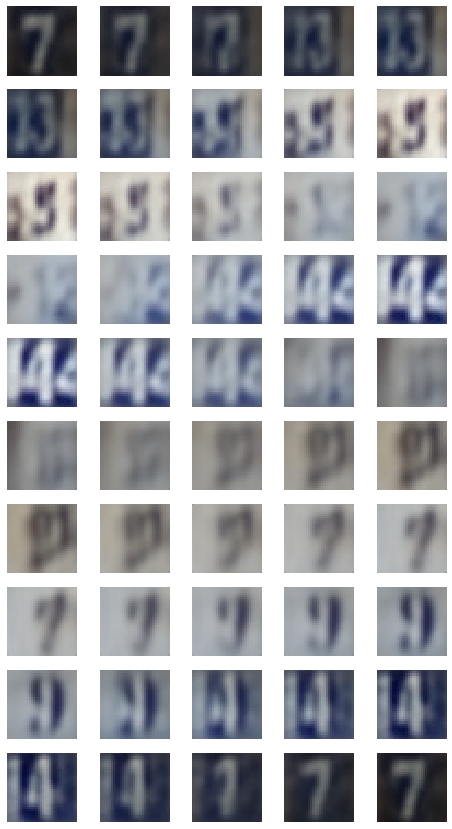

In [0]:
plot_interpolation(10, 5, images)

In [0]:
def sample_(model):
    z = torch.randn([n, 2 * model.channels, 8, 8]).to(device)
    
    with torch.no_grad():
        images, _ = model.decode(z)
        images = np.clip((images.permute(0, 2, 3, 1).cpu().numpy() + 1) / 2, 0, 1)
    
    return images

In [0]:
images = sample_(model)

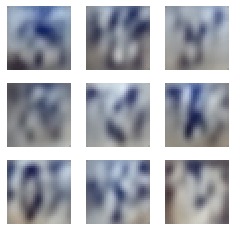

In [0]:
plot_samples(images)

In [0]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, channel_in, channel_out, kernel_size, stride, padding):
        super(MaskedConv2d, self).__init__(channel_in, channel_out, kernel_size, stride, padding, bias=False)
        mask = torch.ones_like(self.weight)
        _, _, h, w = self.weight.size()
        h, w = h // 2, w // 2
        mask[:, :, h, w + (mask_type == 'B'):] = 0
        mask[:, :, h + 1:] = 0
        self.register_buffer('mask', mask)

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

In [0]:
class MaskResBlock(nn.Module):
    def __init__(self, h):
        super(MaskResBlock, self).__init__()
        self.net = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(2 * h, h, 1),
            nn.BatchNorm2d(h),
            nn.ReLU(),
            MaskedConv2d('B', h, h, 3, 1, 1),
            nn.BatchNorm2d(h),
            nn.ReLU(),
            nn.Conv2d(h, 2 * h, 1),
            nn.BatchNorm2d(2 * h)
        )

    def forward(self, x):
        return self.net(x) + x

In [0]:
class PixelCNN(nn.Module):
    def __init__(self, h=128):
        super(PixelCNN, self).__init__()
        
        self.net = nn.Sequential(
            MaskedConv2d('A', h, 2 * h, 3, 1, 1),
            MaskResBlock(h),
            MaskResBlock(h),
            MaskResBlock(h),
            nn.Conv2d(2 * h, 2 * h, kernel_size=1)
        )
            
    def forward(self, x):
        x = self.net(x).reshape(-1, 2, x.shape[1] // 2, 8, 8)
        mu, var = x[:, 0], torch.exp(x[:, 1])
        return mu, var

In [0]:
class VAE2(nn.Module):
    def __init__(self, channels=64):
        super(VAE2, self).__init__()
        self.channels = channels
        self.pixel_cnn = PixelCNN(2 * channels)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, self.channels * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(self.channels * 2, self.channels * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(self.channels * 4, self.channels * 4, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            ResidualStack(self.channels),
            nn.Conv2d(self.channels * 2, self.channels * 4, kernel_size=1)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(self.channels * 2, self.channels * 4, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            ResidualStack(self.channels),
            nn.ConvTranspose2d(self.channels * 2, self.channels * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(),
            nn.ConvTranspose2d(self.channels * 2, 3 * 2, kernel_size=4, stride=2, padding=1, bias=False)
        )
            
    def encode(self, x, training=True):
        x = self.encoder(x).reshape(-1, 2, 2 * self.channels, 8, 8)
        mu_z1, var_z1 = x[:, 0], torch.exp(x[:, 1])
        z = mu_z1 + torch.sqrt(var_z1) * torch.randn_like(mu_z1, device=device)
        mu_z2, var_z2 = self.pixel_cnn(z)

        return (mu_z1, var_z1, mu_z2, var_z2, z) if training else mu_z1
    
    def decode(self, z):
        z = self.decoder(z).reshape(-1, 2, 3, 32, 32)

        return z[:, 0], torch.exp(z[:, 1])
            
    def forward(self, x):
        mu_z1, var_z1, mu_z2, var_z2, z = self.encode(x)
        mu_x, var_x = self.decode(z)
        return mu_z1, var_z1, mu_z2, var_z2, z, mu_x, var_x

In [0]:
model = VAE2(channels=32)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=2e-4)

In [0]:
def train2():
    KLD_t, losses_t, var_t, KLD_v, losses_v, var_v = [], [], [], [], [], []

    for i in trange(epochs):
        it_var, it_KLD, it_loss = [], [], []
        model.train()
        for x in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            mu_z1, var_z1, mu_z2, var_z2, z, mu_x, var_x = model(x)
            mll, KL = MLLLoss(mu_x, var_x, x), KLL(mu_z1, var_z1, mu_z2, var_z2, z)
            total_loss = mll + KL

            it_var.append(mll.item())
            it_KLD.append(KL.item())
            it_loss.append(total_loss.item())

            total_loss.backward()
            optimizer.step()

        var_t.append(np.array(it_var).mean())
        KLD_t.append(np.array(it_KLD).mean())
        losses_t.append(np.array(it_loss).mean())
        it_var, it_KLD, it_loss = [], [], []

        model.eval()
        with torch.no_grad():
            for x in val_loader:
                x = x.to(device)
                mu_z1, var_z1, mu_z2, var_z2, z, mu_x, var_x = model(x)
                mll, KL = MLLLoss(mu_x, var_x, x), KLL(mu_z1, var_z1, mu_z2, var_z2, z)
                total_loss = mll + KL

                it_var.append(mll.item())
                it_KLD.append(KL.item())
                it_loss.append(total_loss.item())

        var_v.append(np.array(it_var).mean())
        KLD_v.append(np.array(it_KLD).mean())
        losses_v.append(np.array(it_loss).mean())

    return var_t, var_v, KLD_t, KLD_v, losses_t, losses_v

In [0]:
var_t, var_v, KLD_t, KLD_v, losses_t, losses_v = train2()

In [0]:
torch.save(model.state_dict(), "./tmp2.pt")

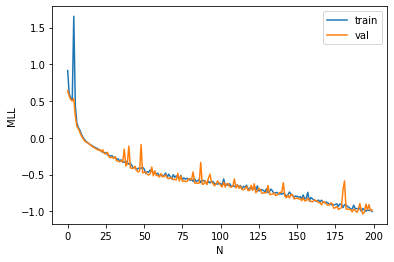

In [0]:
plot_(var_t, var_v, "MLL")

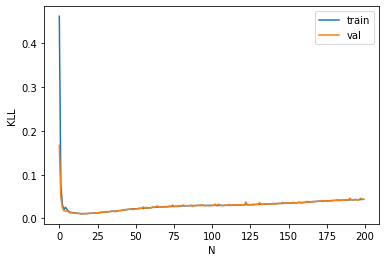

In [0]:
plot_(KLD_t, KLD_v, "KLL")

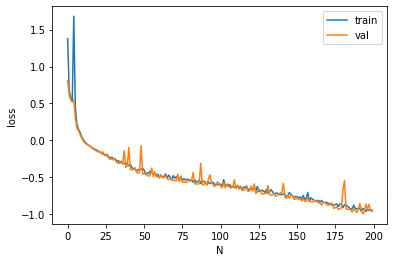

In [0]:
plot_(losses_t, losses_v, "loss")

In [0]:
model.eval()
images = draw_interpolation(model, 10, 5)

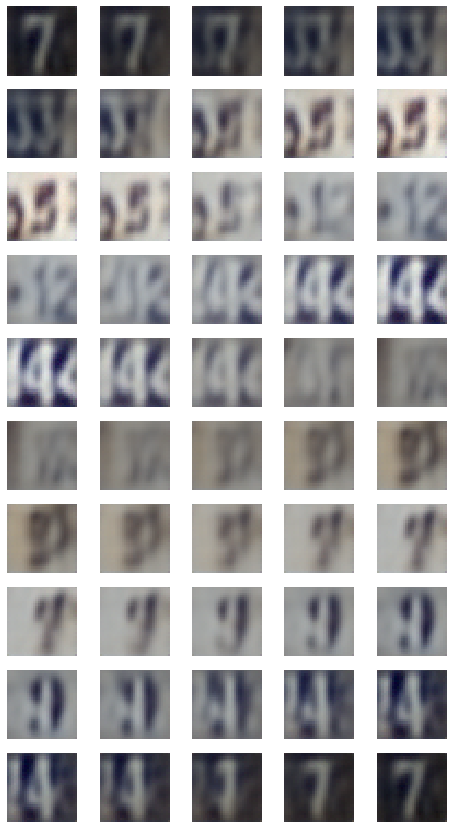

In [0]:
plot_interpolation(10, 5, images)

In [0]:
def sample2_(model):
    z = torch.randn([n, 2 * model.channels, 8, 8]).to(device)
    h, w = 8, 8
    
    with torch.no_grad():
        for y in range(h):
            for x in range(w):
                mu, var = model.pixel_cnn(z)
                mu, var = mu[:, :, y, x], var[:, :, y, x]
                z[:, :, y, x] = model.reparameterize(mu, var)

        images, _ = model.decode(z)
        images = np.clip((images.permute(0, 2, 3, 1).cpu().numpy() + 1) / 2, 0, 1)

    return images

In [0]:
images = sample2_(model)

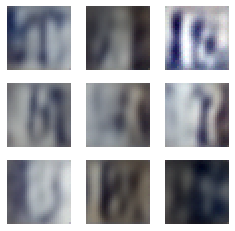

In [0]:
plot_samples(images)